#DNN_Xavier Init/NN Layer#3(784->256->10)/Adam/Cross Entropy
손글씨 분류기

###ML 라이브러리: Pytorch(GPU)

In [1]:
import torch
# torch.vision 라이브러리: 유명한 datasets, 모델 아키텍터, 이미지 transformation(영상 전처리)
import torchvision.datasets as data
import torchvision.transforms as transforms
import random

GPU 사용을 명시적으로 보여주기 & Random Seed 고정하기

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777) #파이썬의 Random Seed
torch.manual_seed(777) #torch의 Random Seed
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

학습 파라미터 설정

In [3]:
learning_rate = 0.001 #갱신 step의 정도
training_epochs = 15 #epoch
batch_size = 100 #batch

##1. 데이터셋 불러오기

In [4]:
#torchvision.datasets.MNIST(root = 'MNIST_data/', train = True, transform = transforms.ToTensor(), download = True)
#root: 데이터셋의 위치
#train = True: 학습 데이터, train = False: 테스트 데이터
#transform = transforms.ToTensor(): 텐서로 영상 전처리
#download = True: root에 데이터셋이 없으면 다운로드
mnist_train = data.MNIST(root = 'MNIST_data/', train = True, transform = transforms.ToTensor(), download = True)

mnist_test = data.MNIST(root = 'MNIST_data/', train = False, transform = transforms.ToTensor(), download = True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


DataLoader: 데이터를 알맞게 나눠준다

In [5]:
data_loader = torch.utils.data.DataLoader(dataset = mnist_train, batch_size = batch_size, shuffle = True, drop_last = True)
#dataset = mnist_train: 처리할 데이터
#batch_size = batch_size: batch_size만큼씩 데이터를 잘라러 준다
#shuffle = True: 데이터를 섞는다
#drop_last: 모든 데이터 개수 % batch_size > 0 일 때 나머지 데이터를 버린다

##5. 모델 추정

###모델 정의: DNN_Xavier Init/NN Layer#3(784->256->10)/Adam/Cross Entropy

NN Layer #3: 784 -> 256 -> 10

In [6]:
linear1 = torch.nn.Linear(784, 256, bias = True) #784 dimension -> 256 dimension
linear2 = torch.nn.Linear(256, 256, bias = True)
linear3 = torch.nn.Linear(256, 10, bias = True) #256 dimension -> 10 class
relu = torch.nn.ReLU()

Weight Initialization: Xavier Init

In [7]:
torch.nn.init.xavier_normal_(linear1.weight)
torch.nn.init.xavier_normal_(linear2.weight)
torch.nn.init.xavier_normal_(linear3.weight)

Parameter containing:
tensor([[-0.0576,  0.0576,  0.0621,  ..., -0.0264, -0.0776, -0.0692],
        [-0.1044,  0.2128, -0.1567,  ..., -0.1486, -0.0039,  0.0335],
        [ 0.0296,  0.0270, -0.1666,  ..., -0.0392, -0.0594,  0.0838],
        ...,
        [ 0.1207, -0.0351,  0.0203,  ..., -0.0716, -0.0728,  0.1718],
        [ 0.0903,  0.0185, -0.0036,  ...,  0.1521, -0.0560, -0.0071],
        [-0.0101, -0.1101,  0.0711,  ..., -0.0720, -0.0435,  0.0051]],
       requires_grad=True)

.Sequential로 모델을 순서대로 묶는다<br>
.to(device): device = 'cuda' 모델을 gpu 메모리에 저장한다

In [8]:
# 마지막 layer에는 ReLU가 없는 것이 좋다
# layer1(linear1 & ReLU) -> layer2(linear2 & ReLU) -> layer3(linear3)
model = torch.nn.Sequential(linear1, relu, linear2, relu, linear3).to(device)

In [9]:
model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=10, bias=True)
)

###모델 학습

Cross Entropy Loss & Adam

In [10]:
loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [11]:
#total_batch = 전체 데이터 수 / batch_size
total_batch = len(data_loader) #600 = 60,000 / 100

for epoch in range(training_epochs):
  avg_cost = 0

  for X, Y in data_loader: #앞에서 알맞게 나눠둔 데이터를 X, Y에 넣어준다

    # (mini batch_size, 1, 가로, 세로)
    # (100, 1, 28, 28) 크기의 텐서를 (100, 28*28) 크기의 텐서로 바꿔준다
    X = X.view(-1, 28 * 28).to(device) # 2D 데이터를 1D 데이터로 눌러준다
    # One-hot Encoding되어 있지 않다
    Y = Y.to(device)

    #Gradient Initialization
    optimizer.zero_grad()

    # Forward 계산
    hypothesis = model(X)

    # Cost : Error 계산
    cost = loss(hypothesis, Y)

    # Backpropagation
    cost.backward()

    # Cost로 가중치(W, b) 갱신
    optimizer.step()

    #평균 Error 계산
    avg_cost += cost / total_batch

  print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.246770531
Epoch: 0002 cost = 0.094472416
Epoch: 0003 cost = 0.061146256
Epoch: 0004 cost = 0.044512525
Epoch: 0005 cost = 0.031672131
Epoch: 0006 cost = 0.028010052
Epoch: 0007 cost = 0.020296926
Epoch: 0008 cost = 0.017233189
Epoch: 0009 cost = 0.015233908
Epoch: 0010 cost = 0.015294536
Epoch: 0011 cost = 0.015270354
Epoch: 0012 cost = 0.009641190
Epoch: 0013 cost = 0.009923711
Epoch: 0014 cost = 0.009399245
Epoch: 0015 cost = 0.010564849
Learning finished


##6. 결과 분석

Accuracy

In [12]:
#앞서 모델 학습 과정에서는 required_grad = True로 되어있어 학습 중임을 나타낸다
#False는 학습 중이 아님을, 모델 평가 중임을 나타낸다

with torch.no_grad(): #임시로 required_grad = False로 설정하는 것과 같다

  X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
  Y_test = mnist_test.test_labels.to(device)

  prediction = model(X_test)

  correct_prediction = torch.argmax(prediction, 1) == Y_test

  accuracy = correct_prediction.float().mean()

  print('Accuracy:', accuracy.item())

Accuracy: 0.9801999926567078


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Random Test: 한 데이터만

In [13]:
r = random.randint(0, len(mnist_test) - 1)
X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

print('Label: ', Y_single_data.item())
single_prediction = model(X_single_data)
print('Prediction: ', torch.argmax(single_prediction, 1).item())

Label:  8
Prediction:  8


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Random Test한 데이터 시각화하기

tensor([8], device='cuda:0')


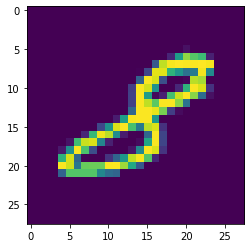

In [14]:
import matplotlib.pyplot as plt
plt.imshow(X_single_data.reshape(28,28).cpu()) # 1D -> 2D
print(Y_single_data)